# Create a RF model

# Plan:

reference: https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/

https://dziganto.github.io/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-Train-Test-Split/

https://www.kaggle.com/mukultiwari/titanic-top-14-with-random-forest

https://www.google.ca/search?sxsrf=ACYBGNRBWF_aQ2yiljm6BTm60VIAwBcBQw%3A1568926860954&source=hp&ei=jOyDXcXrN-eP5wLO2IjgCQ&q=titanic+random+forest+python&oq=titanic+random+forest+python&gs_l=psy-ab.3..0j0i22i30l2.182.6663..6860...0.0..0.110.1743.18j3......0....1..gws-wiz.......35i39j0i131.OwubVIkUbkY&ved=0ahUKEwjF4eSB5N3kAhXnx1kKHU4sApwQ4dUDCAg&uact=5

1. Do train/test split (80/20)
2. Do train/validation/test split (60/20/20) for hyperparameter tuning, if applicable.
3. Using hyper parmeters from 2. (Lasso and regularization and etc using CV, k fold and etc), re-model RF using train/test split (80/20)
4. Compare the results (Accuracy, AUC and etc) from 3 and 1. See if 3. improved predictive power or not.

# pull_data.py (5 points) 
When this is called using python pull_data.py in the command line, this will go to the 2 Kaggle urls provided below, authenticate using your own Kaggle sign on, pull the two datasets, and save as .csv files in the current local directory. The authentication login details (aka secrets) need to be in a hidden folder (hint: use .gitignore). There must be a data check step to ensure the data has been pulled correctly and clear commenting and documentation for each step inside the .py file. Training dataset url: https://www.kaggle.com/c/titanic/download/train.csv Scoring dataset url: https://www.kaggle.com/c/titanic/download/test.csv

In [1]:
import os
import zipfile
import kaggle as kg
import pandas as pd

os.environ['KAGGLE_USERNAME'] = 'an11dy'
os.environ['KAGGLE_KEY'] = '2a58bbf01928d5b2e914a87d5d4aee75'
#!kaggle competitions download -c titanic

In [2]:
kg.api.authenticate()
kg.api.competition_download_files("titanic")

In [3]:
zf = zipfile.ZipFile('titanic.zip') # importing zip file from local path
train = pd.read_csv(zf.open('train.csv')) # open train.csv
test = pd.read_csv(zf.open('test.csv')) # open test.csv

# train_model.py (5 points) 
When this is called using python train_model.py in the command line, this will take in the training dataset csv, perform the necessary data cleaning and imputation, and fit a classification model to the dependent Y. There must be data check steps and clear commenting for each step inside the .py file. The output for running this file is the random forest model saved as a .pkl file in the local directory. Remember that the thought process and decision for why you chose the final model must be clearly documented in this section. eda.ipynb

In [4]:
# Pandas is used for data manipulation
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import seaborn as sns
import numpy as np
import math
# Read in data and display first 5 rows
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# data pre-processing

## Summary statistics

The training data set contains 891 observations and 11 variables including the binary response variable, Survived (0/1).
Of these columns, 6 are numeric and 5 are objects (categorical or simply text).

In the following tables, we see the summary statistics for all of the variables in the dataset. They have been broken up into 3 tables for ease of reading. Note that Fare, SibSp and Parch have fairly positively skew which may need to be addressed before developing a model; other predictors show skew and kurtosis, but to a lesser degree. 
Also, Cabin (77%) and Age (19.8%) have considerable amount of missing data. We may have to drop Cabin or transform it into binary (assuming NaN means don't have any cabin). For Age, we will apply imputation technique (e.g mean, mode).

In [5]:
# exclude PassengerId, Name
train = train.drop(['Name','PassengerId'], axis=1)

In [6]:
print("Summary statistics:")
print(train.describe())
print("")
print("Kurtosis statistics:")
print(train.kurtosis())
print("")
print("Skewness statistics:")
print(train.skew())

Summary statistics:
         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

Kurtosis statistics:
Survived    -1.775005
Pclass      -1.280015
Age          0.178274
SibSp       17.880420
Parch        9.778125
Fare        33.398141
dtype: float64

Skewness statistics:
Survived    0.478523
Pclass     -0.630548
Age         0.389108
SibSp       3.695352
Par

In [7]:
print("Data information")
print(train.info())
print("")
print("Number of missing rows")
print(train.isnull().sum())
print("")
print("Percent of missing rows")
print( (train.isnull().sum()/len(train)) * 100)

Data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 69.7+ KB
None

Number of missing rows
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Percent of missing rows
Survived     0.000000
Pclass       0.000000
Sex          0.000000
Age         19.865320
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
Cabin       77.104377
Embarked     0.224467
dtype: float64


In [8]:
train = train.drop(['Cabin'], axis=1)

# Univariate distributions

## Histogram
The histogram for all numerical variables shows that Age may benefit from transformation through BoxCox/YeoJohnson. We may need to transform this variable, only if applicable. 

Keep in mind that Sibsp and Parch should be treated as discrete numeric variables (data types are in int64) and Survived is dependent binary variable (but data type is still in int64). Sibsp and Parch are not evenly distributed so we will need to apply imputation if it is applicable. 

Note that continous numerical variable such as Fare might not be normalized even after transformation as it is too far away from a normal distribution. I will, regardless, apply BoxCox/YeoJohnson for this variable, only if applicable.

As we expected from summary statistics, numerical variables, except for Age, are all pretty skewed or unbalanced. 

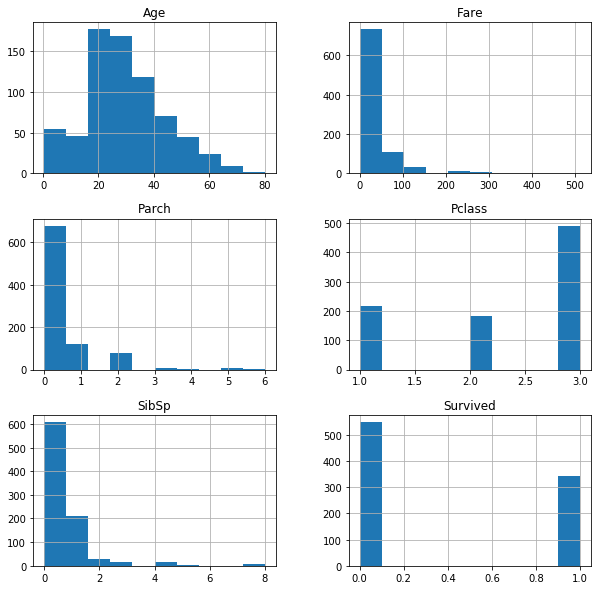

In [9]:
#plt.figure()
train.hist(figsize=(10,10))
plt.show()

## Correlation matrix

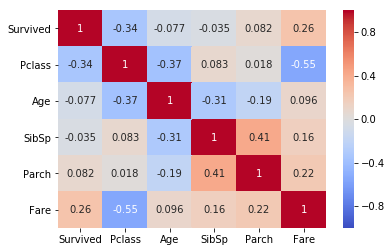

In [10]:
sns.heatmap(train.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True)

Pclass is fairly strongly correlated with Fare but not so much. I would not drop any variable.

## Boxplot
Below is the result of boxplot for continous numerical variables such as Age and Fare grouped by Survived and barplot for Survival count. 

We see that survival rate tend to increase when age decreases and fare increases.

We have somewhat imbalanced proportion of depedent variable; we have substantially more 0 (not survived) than 1 (survived).
Since we have imbalance, F1score (not Accuracy) as evalulation metrics for model selection will be a reasonable choice but depending on the objective, we could still use Accuracy. For this excercise, our final evalulation will be still based on Accuracy.

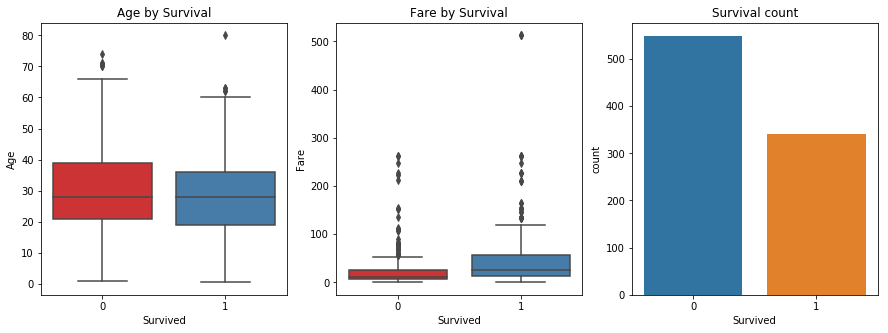

In [11]:
fx, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].set_title('Age by Survival')
axes[1].set_title('Fare by Survival')
axes[2].set_title('Survival count')
sns.boxplot(x="Survived", y="Age", data=train, palette="Set1", ax=axes[0])
sns.boxplot(x="Survived", y="Fare", data=train, palette="Set1", ax=axes[1])
sns.countplot(x=train.Survived, ax=axes[2])

# Count and barplot
We know that there is imbalanced proportion of class for each categorical variable. Note that survival rate for female is much higher than male despite of the fact that there were much fewer females. 

To summarize what we found from the plots and histograms, we know that Age and Fare are continous numeric where as PClass and Parch are discrete numeric. Survived is binary dependent varaible and rest of them in the plots are categorical. 

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


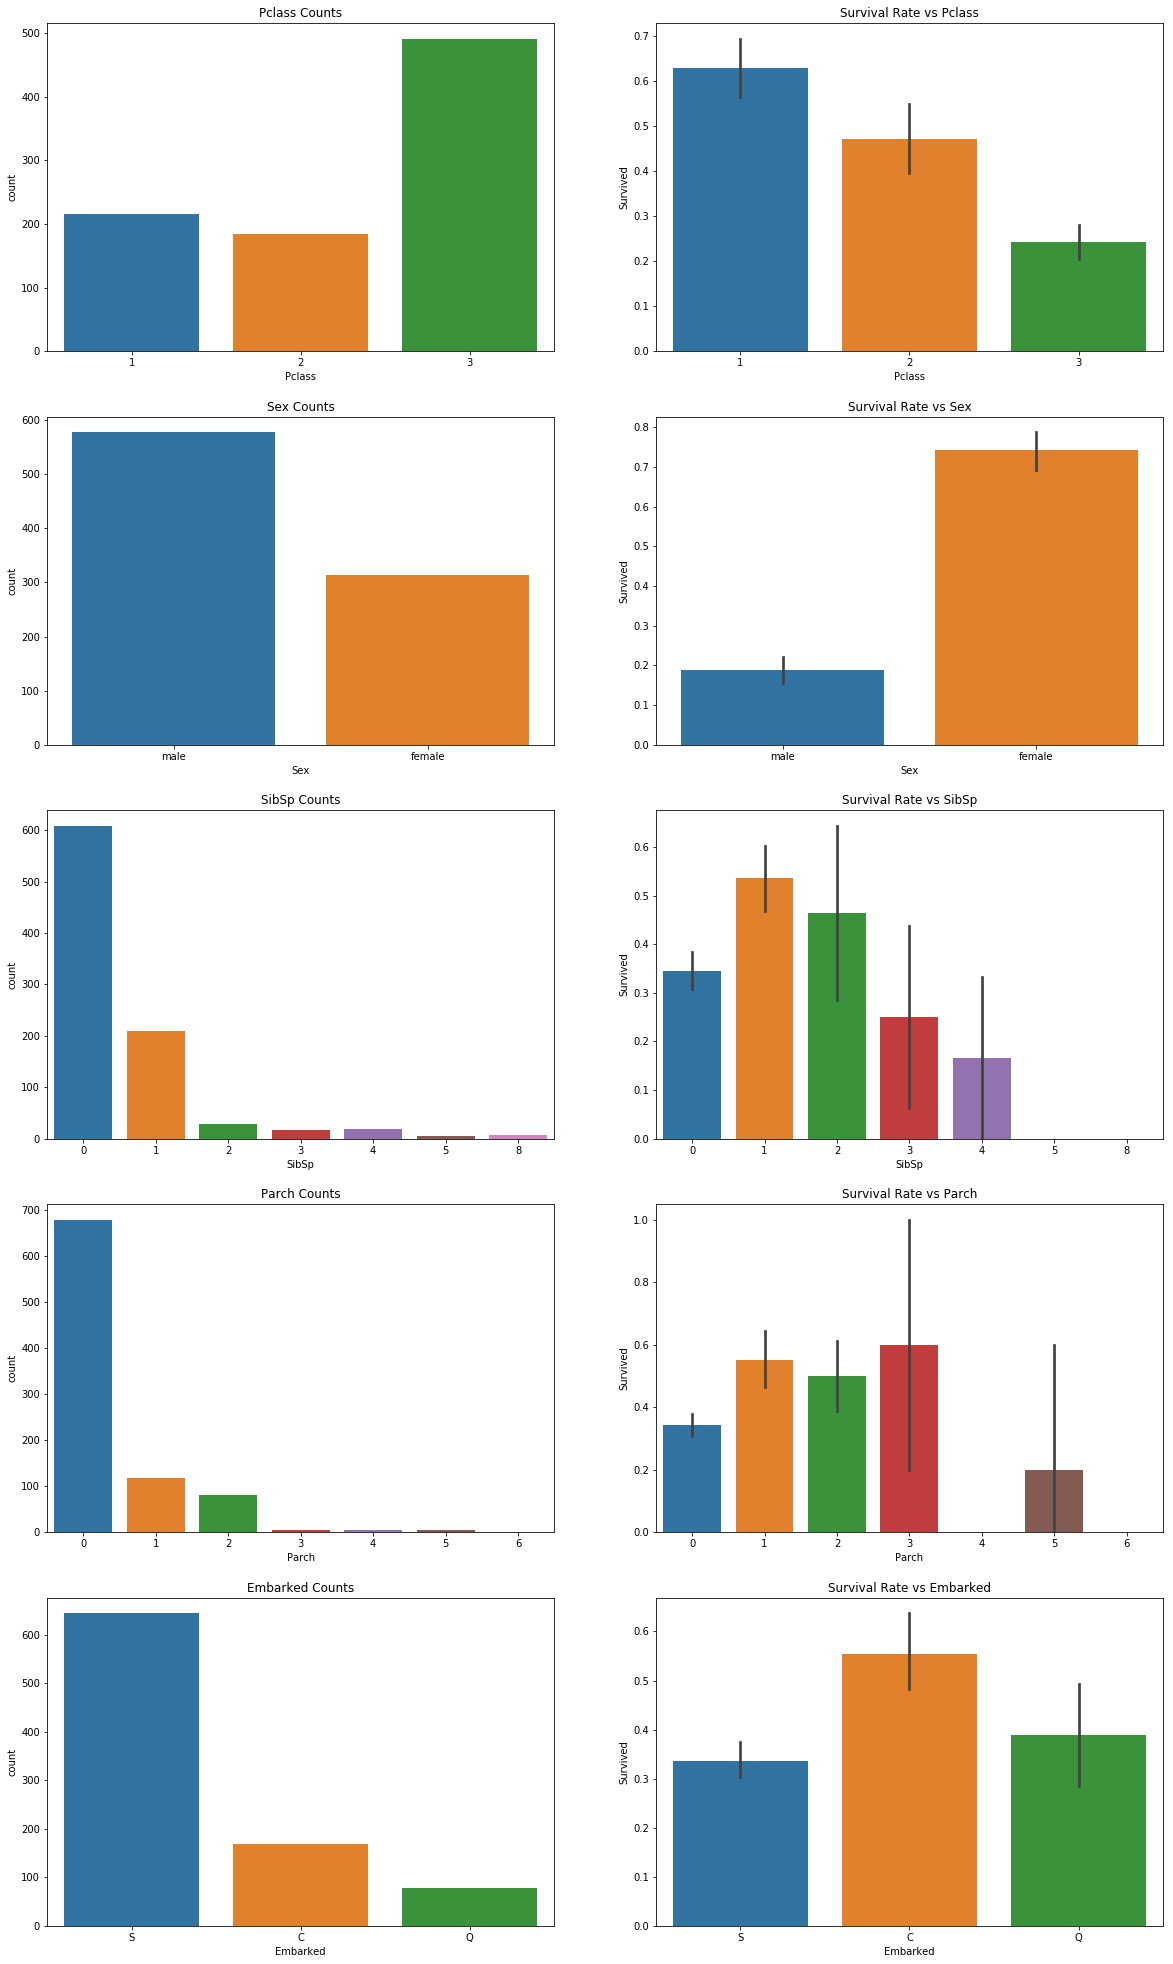

In [12]:
fx, axes = plt.subplots(5, 2, figsize=(20,35))
names = ['Pclass','Sex','SibSp','Parch','Embarked']

for i,j in zip(names,range(0,5)):
    axes[j][0].set_title(str(i) + ' Counts')
    axes[j][1].set_title('Survival Rate vs ' + str(i))
    fig1_embarked = sns.countplot(x=train.loc[:,i], ax=axes[j][0])
    fig2_embarked = sns.barplot(x=train.loc[:,i], y=train.Survived, ax=axes[j][1])


# Data preparation

Since we know Cabin is missing 77% of rows, we will drop this variable. Ticket will be dropped as well.

For Embarked, since we are missing only 2 rows, we will apply Mode imputation. 

For Age, we will apply Mean & KNN imputation and then round down the result since KNN could give me values in decimal.

For Embarked and Sex, we will decode the values into numeric variable for KNN imputation - dummy variables

In [13]:
# Impute with Mode - Embarked
train['Embarked'] = train['Embarked'].fillna('S')

# Drop Ticket
train = train.drop(['Ticket'], axis=1)

In [14]:
# Dummy variable with one hot-coded - Gender & Embarked
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)

train = ohe.fit_transform(train)

# Multicollinearity & Dummy variable trap

Now we created dummy variables using sparse matrix techniques through OneHotEncoder(). We now have to watch out multicollinearity problem. 

"Multicollinearity refers to a situation in which two or more explanatory variables in a multiple regression model are highly linearly related. We have perfect multicollinearity if, for example as in the equation above, the correlation between two independent variables is equal to 1 or −1."


For Random Forest model, multicollinearity and dummy variable trap won't affect prediction result but it will still affect feature importance. (https://stats.stackexchange.com/questions/377033/collinearity-of-features-and-random-forest)

We will have to drop Sex_female as it is perfectly correlated with Sex_male which can distort the meaning of feature importance.

In [15]:
train.corr()

,Survived,Pclass,Sex_male,Sex_female,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
Survived,1.000000,-0.338481,-0.543351,0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.149683,0.168240,0.003650
Pclass,-0.338481,1.000000,0.131900,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.074053,-0.243292,0.221009
Sex_male,-0.543351,0.131900,1.000000,-1.000000,0.093254,-0.114631,-0.245489,-0.182333,0.119224,-0.082853,-0.074115
Sex_female,0.543351,-0.131900,-1.000000,1.000000,-0.093254,0.114631,0.245489,0.182333,-0.119224,0.082853,0.074115
Age,-0.077221,-0.369226,0.093254,-0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.023233,0.036261,-0.022405
SibSp,-0.035322,0.083081,-0.114631,0.114631,-0.308247,1.000000,0.414838,0.159651,0.068734,-0.059528,-0.026354
Parch,0.081629,0.018443,-0.245489,0.245489,-0.189119,0.414838,1.000000,0.216225,0.060814,-0.011069,-0.081228
Fare,0.257307,-0.549500,-0.182333,0.182333,0.096067,0.159651,0.216225,1.000000,-0.162184,0.269335,-0.117216
Embarked_S,-0.149683,0.074053,0.119224,-0.119224,-0.023233,0.068734,0.060814,-0.162184,1.000000,-0.782742,-0.499421
Embarked_C,0.168240,-0.243292,-0.082853,0.082853,0.036261,-0.059528,-0.011069,0.269335,-0.782742,1.000000,-0.148258


In [16]:
train = train.drop(['Sex_female'], axis=1) 

In [17]:
# Impute with mean - Age -- Let's keep original train dataset just in case.
train_mean = train.copy()
train_mean['Age'] = train_mean['Age'].fillna(train_mean.Age.mean())
age_floor = list(map(lambda x: math.floor(x), train_mean.Age))

train_mean['Age'] = age_floor
train_mean.head(10)

,Survived,Pclass,Sex_male,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
0,0,3,1,22,1,0,7.2500,1,0,0
1,1,1,0,38,1,0,71.2833,0,1,0
2,1,3,0,26,0,0,7.9250,1,0,0
3,1,1,0,35,1,0,53.1000,1,0,0
4,0,3,1,35,0,0,8.0500,1,0,0
5,0,3,1,29,0,0,8.4583,0,0,1
6,0,1,1,54,0,0,51.8625,1,0,0
7,0,3,1,2,3,1,21.0750,1,0,0
8,1,3,0,27,0,2,11.1333,1,0,0
9,1,2,0,14,1,0,30.0708,0,1,0


In [18]:
# Impute with KNN - Age
from missingpy import KNNImputer
imputer = KNNImputer()
X_imputed = imputer.fit_transform(train)

train_knn = pd.DataFrame(pd.DataFrame(X_imputed))
train_knn.columns = train.columns

age_floor = list(map(lambda x: math.floor(x), train_knn.Age))
train_knn['Age'] = age_floor
train_knn.head(10)

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)
C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:432: DeprecationWarning: 'warn_on_dtype' is deprecated in version 0.21 and will be removed in 0.23. Don't set `warn_on_dtype` to remove this warning.
  DeprecationWarning)


,Survived,Pclass,Sex_male,Age,SibSp,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q
0,0.0,3.0,1.0,22,1.0,0.0,7.2500,1.0,0.0,0.0
1,1.0,1.0,0.0,38,1.0,0.0,71.2833,0.0,1.0,0.0
2,1.0,3.0,0.0,26,0.0,0.0,7.9250,1.0,0.0,0.0
3,1.0,1.0,0.0,35,1.0,0.0,53.1000,1.0,0.0,0.0
4,0.0,3.0,1.0,35,0.0,0.0,8.0500,1.0,0.0,0.0
5,0.0,3.0,1.0,47,0.0,0.0,8.4583,0.0,0.0,1.0
6,0.0,1.0,1.0,54,0.0,0.0,51.8625,1.0,0.0,0.0
7,0.0,3.0,1.0,2,3.0,1.0,21.0750,1.0,0.0,0.0
8,1.0,3.0,0.0,27,0.0,2.0,11.1333,1.0,0.0,0.0
9,1.0,2.0,0.0,14,1.0,0.0,30.0708,0.0,1.0,0.0


# Modelling

## model 1: Random Forest using train_knn (imputation of Age with knn)

In [19]:
x = train_knn.drop('Survived',axis=1)
y = train_knn.Survived

In [20]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(x,y,test_size=0.20, random_state=2019)

In [21]:
Results = pd.DataFrame({'Model': [],'Accuracy Score': []})

from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2500, max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)

from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['RandomForestClassifier - Age with KNN'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})

Results = Results.append(res)

In [22]:
#model = model.fit(trainX, trainY)
#scores = cross_val_score(model, trainX, trainY, cv=5)
from sklearn.model_selection import cross_val_score
model = model.fit(x, y)
scores = cross_val_score(model, x, y, cv=5)

# Hm.. maybe for RF we just keep them
res = pd.DataFrame({"Model":['RandomForestClassifier CV - Age with KNN'],
                    "Accuracy Score": [scores.mean()]})

Results = Results.append(res)

## model 1-2: Random Forest using train_mean (imputation of Age with mean)

In [23]:
x2 = train_mean.drop('Survived',axis=1)
y2 = train_mean.Survived

In [24]:
from sklearn.model_selection import train_test_split
trainX2, testX2, trainY2, testY2 = train_test_split(x2,y2,test_size=0.20, random_state=2019)

In [25]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2500, max_depth=4)
model.fit(trainX2, trainY2)
y_pred2 = model.predict(testX2)

from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['RandomForestClassifier - Age with mean'],
                    "Accuracy Score": [accuracy_score(y_pred2,testY2)]})

Results = Results.append(res)

In [26]:
#model = model.fit(trainX, trainY)
#scores = cross_val_score(model, trainX, trainY, cv=5)
model = model.fit(x2, y2)
scores2 = cross_val_score(model, x2, y2, cv=5)

res = pd.DataFrame({"Model":['RandomForestClassifier CV - Age with mean'],
                    "Accuracy Score": [scores2.mean()]})

Results = Results.append(res)

In [27]:
Results

,Model,Accuracy Score
0,RandomForestClassifier - Age with KNN,0.826816
0,RandomForestClassifier CV - Age with KNN,0.822734
0,RandomForestClassifier - Age with mean,0.826816
0,RandomForestClassifier CV - Age with mean,0.819344


Since Accuracy for Age with KNN imputation is generally stable (difference between CV and non-cv is not that huge compared to with mean) we will use train_knn as dataframe for the next model evaluation

## other models

In [28]:
from xgboost.sklearn import XGBClassifier
model = XGBClassifier(learning_rate=0.001,n_estimators=2500,
                                max_depth=4, min_child_weight=0,
                                gamma=0, subsample=0.7,
                                colsample_bytree=0.7,
                                scale_pos_weight=1, seed=27,
                                reg_alpha=0.00006)
model.fit(trainX, trainY)
y_pred = model.predict(testX)

res = pd.DataFrame({"Model":['XGBClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [29]:
#model = model.fit(trainX, trainY)
#scores = cross_val_score(model, trainX, trainY, cv=5)
model = model.fit(x, y)
scores = cross_val_score(model, x, y, cv=5)

res = pd.DataFrame({"Model":['XGBClassifier CV'],
                    "Accuracy Score": [scores.mean()]})

Results = Results.append(res)

In [30]:
from sklearn.svm import SVC
model = SVC()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
res = pd.DataFrame({"Model":['SVC'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [31]:
#model = model.fit(trainX, trainY)
#scores = cross_val_score(model, trainX, trainY, cv=5)
model = model.fit(x, y)
scores = cross_val_score(model, x, y, cv=5)

res = pd.DataFrame({"Model":['SVC CV'],
                    "Accuracy Score": [scores.mean()]})

Results = Results.append(res)

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\U

In [32]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
res = pd.DataFrame({"Model":['LogisticRegression'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [33]:
#model = model.fit(trainX, trainY)
#scores = cross_val_score(model, trainX, trainY, cv=5)
model = model.fit(x, y)
scores = cross_val_score(model, x, y, cv=5)

res = pd.DataFrame({"Model":['LogisticRegression CV'],
                    "Accuracy Score": [scores.mean()]})

Results = Results.append(res)

C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahwang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\

In [34]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=4)
model.fit(trainX, trainY)
y_pred = model.predict(testX)
res = pd.DataFrame({"Model":['DecisionTreeClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [35]:
#model = model.fit(trainX, trainY)
#scores = cross_val_score(model, trainX, trainY, cv=5)
model = model.fit(x, y)
scores = cross_val_score(model, x, y, cv=5)

res = pd.DataFrame({"Model":['DecisionTreeClassifier CV'],
                    "Accuracy Score": [scores.mean()]})

Results = Results.append(res)

In [36]:
from sklearn.tree import export_graphviz
export_graphviz(model, out_file='tree_limited.dot', feature_names = x.columns,
                rounded = True, proportion = False, precision = 2, filled = True)
!dot -Tpng tree_limited.dot -o tree_limited.png -Gdpi=600

In [37]:
from IPython.display import Image
Image(filename = 'tree_limited.png')

In [38]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(trainX, trainY)
y_pred = model.predict(testX)
res = pd.DataFrame({"Model":['KNeighborsClassifier'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})
Results = Results.append(res)

In [39]:
#model = model.fit(trainX, trainY)
#scores = cross_val_score(model, trainX, trainY, cv=5)
model = model.fit(x, y)
scores = cross_val_score(model, x, y, cv=5)

res = pd.DataFrame({"Model":['KNeighborsClassifier CV'],
                    "Accuracy Score": [scores.mean()]})

Results = Results.append(res)

In [40]:
Results

,Model,Accuracy Score
0,RandomForestClassifier - Age with KNN,0.826816
0,RandomForestClassifier CV - Age with KNN,0.822734
0,RandomForestClassifier - Age with mean,0.826816
0,RandomForestClassifier CV - Age with mean,0.819344
0,XGBClassifier,0.832402
0,XGBClassifier CV,0.822765
0,SVC,0.698324
0,SVC CV,0.726273
0,LogisticRegression,0.798883
0,LogisticRegression CV,0.796884


# Hyperparameter tuning

We will perform hyperparameter tuning for Random Forest using Grid CV and RandomizedSearch CV.

## param_grid set up

In [41]:
# Import necessary modules
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Create the hyperparameter grid
n_estimators = [int(x) for x in np.linspace(start = 2500, stop = 3000, num = 2)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators, 'bootstrap': bootstrap,
#               'max_features': max_features,
               'max_depth': max_depth, 'criterion': ['gini', 'entropy']} #,
#               'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
#              'bootstrap': bootstrap}

param_grid

{'n_estimators': [2500, 3000],
 'bootstrap': [True, False],
 'max_depth': [5, 6, 7, 8, 10],
 'criterion': ['gini', 'entropy']}

## GridSearchCV

In [42]:
#Tuned RF Parameter: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 3000}
#Tuned RF Accuracy: 0.8314606741573034

# Instantiate the Random Forest classifier: rf
rf = RandomForestClassifier()

# Instantiate the GridSearchCV object: rf_cv
rf_cv = GridSearchCV(rf, param_grid, cv=5)

# Fit it to the training data
rf_cv.fit(trainX, trainY)

# Print the optimal parameters and best score
print("Tuned RF Parameter: {}".format(rf_cv.best_params_))
print("Tuned RF Accuracy: {}".format(rf_cv.best_score_))

Tuned RF Parameter: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 3000}
Tuned RF Accuracy: 0.8356741573033708


## RandomizedSearchCV

In [43]:
# Instantiate the RandomizedSearchCV object: rf_cv
#rf_cv = RandomizedSearchCV(rf, param_grid, cv=5)

# Fit it to the data
#rf_cv.fit(trainX, trainY)

# Print the tuned parameters and score
#print("Tuned RF Parameter: {}".format(rf_cv.best_params_))
#print("Tuned RF Accuracy: {}".format(rf_cv.best_score_))

From the result above, we will follow parameters from GridSearchCV.

## Random Forest using train_knn with hyperparameters

In [44]:
model = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth = 8, n_estimators = 3000)
model.fit(trainX, trainY)
y_pred = model.predict(testX)

from sklearn.metrics import accuracy_score
res = pd.DataFrame({"Model":['RandomForestClassifier - Age with KNN (Hyperparameter)'],
                    "Accuracy Score": [accuracy_score(y_pred,testY)]})

Results = Results.append(res)
Results

,Model,Accuracy Score
0,RandomForestClassifier - Age with KNN,0.826816
0,RandomForestClassifier CV - Age with KNN,0.822734
0,RandomForestClassifier - Age with mean,0.826816
0,RandomForestClassifier CV - Age with mean,0.819344
0,XGBClassifier,0.832402
0,XGBClassifier CV,0.822765
0,SVC,0.698324
0,SVC CV,0.726273
0,LogisticRegression,0.798883
0,LogisticRegression CV,0.796884


Sex_male is the most significant in relationship to the target response, followed by Fare and Age. Other features are much less important than these 3.

In [46]:
pd.DataFrame(list(zip(trainX.columns, np.transpose(model.feature_importances_))) \
            ).sort_values(1, ascending=False)

,0,1
1,Sex_male,0.286699
5,Fare,0.234546
2,Age,0.216361
0,Pclass,0.106668
3,SibSp,0.066228
4,Parch,0.040817
6,Embarked_S,0.020257
7,Embarked_C,0.016987
8,Embarked_Q,0.011437


# Conclusion

Through careful imputation for missing data, dummy variable creation and removing variable, we achieved >80% accuracy in most of models. 

We will stick to Random Forest - Age with KNN to be saved as a .pkl file, as it is our main purpose of this excercise. We will return the model with hyperparameter as a final output.